<a href="https://colab.research.google.com/github/Dimildizio/DS_course/blob/main/Neural_networks/Transformers/AG_news_transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Attention mechanism and Transformers

Task: AG news classifiction

## Imports

In [2]:
!pip install pymorphy2 -q
!pip install datasets -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 944.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 26.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.0 MB/s eta 0:00:00


In [5]:
import os
import numpy as np
import math
import matplotlib.pyplot as plt
import pymorphy2
import re
import random
import seaborn as sns
import string
import time

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

import datasets
from datasets import load_dataset

import nltk

from collections import Counter
from dataclasses import dataclass
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
from transformers import get_scheduler
from transformers import BertTokenizer, BertModel
from typing import List

sns.set(palette='summer')

In [4]:
nltk.download('punkt')
nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

### Create tensorboard

In [ ]:
%load_ext tensorboard

log_dir = "./logs"
if not os.path.exists(log_dir):
    os.makedirs(log_dir)
writer = SummaryWriter(log_dir)
%tensorboard --logdir {log_dir}

## Set config

In [10]:
@dataclass
class CFG:
  bert_model = 'bert-base-cased'
  custom_name = 'model_v0'
  batch_size = 32
  lr = 1e-5
  attention_head = 1
  train_size = 20000
  test_size = 1000
  padding_idx = 0
  hdden_dim = 768
  scheduler_lambda = 0.96

In [11]:
STOP_WORDS = set(stopwords.words('english'))
PUNCT_TOKENIZER = nltk.WordPunctTokenizer()
MORPH = pymorphy2.MorphAnalyzer()

### Freeze seeds for reproducibility

In [12]:
def seed_everything(seed=42):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [13]:
seed_everything()

## Data preparation

In [37]:
LABEL_NAMES = {
    0: "World",
    1: "Sports",
    2: "Business",
    3: "Science/Technology"}

In [14]:
dataset = datasets.load_dataset('ag_news')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

In [26]:
def preprocess_text(text):
    nums_filtered_text = re.sub(r'[0-9]+', '', text.lower())
    words = ' '.join([re.sub(r'[%s]' % re.escape(string.punctuation), ' ', word) for word in nums_filtered_text.split()])
    punct_filtered_text = ''.join([ch for ch in words if ch not in string.punctuation])
    tokens = PUNCT_TOKENIZER.tokenize(punct_filtered_text)
    filtr_stop_words_tokens = [MORPH.parse(token)[0].normal_form for token in tokens
                             if token not in STOP_WORDS]
    norm_tokens = [MORPH.parse(token)[0].normal_form for token in filtr_stop_words_tokens]

    return f"[CLS] {' '.join(norm_tokens)}"

In [27]:
X = dataset['train']['text']
y = dataset['train']['label']

X_test = dataset['test']['text']
y_test = dataset['test']['label']

In [87]:
sent_num = np.random.randint(len(X))
print(f"Label: {y[sent_num]} {LABEL_NAMES[y[sent_num]]}:\n\nOriginal {sent_num}:\n\t{X[sent_num]}\n\nPreprocessed:\n\t{preprocess_text(X[sent_num])}")

Label: 3 Science/Technology:

Original 41606:
	Intel Corp. Makes Marketing Push for Centrino Chip  SAN FRANCISCO (Reuters) - Intel Corp. &lt;A HREF="http://www.reuters.co.uk/financeQuoteLookup.jhtml?ticker=INTC.O qtype=sym infotype=info qcat=news"&gt;INTC.O&lt;/A&gt; on Monday  launched a global advertising campaign for its Centrino  notebook computer chips, aiming to boost sales of a brand that  has brought the world's largest chip maker more than \$3 billion  in revenue since its start last year.

Preprocessed:
	[CLS] intel corp makes marketing push centrino chip san francisco reuters intel corp lt href http www reuters co uk financequotelookup jhtml ticker intc qtype sym infotype info qcat news gt intc lt gt monday launched global advertising campaign centrino notebook computer chips aiming boost sales brand brought world largest chip maker billion revenue since start last year


In [ ]:
lengs = []
lengs = [len(TOKENIZER.tokenize(train_json['text'])) for train_json in tqdm(X)]

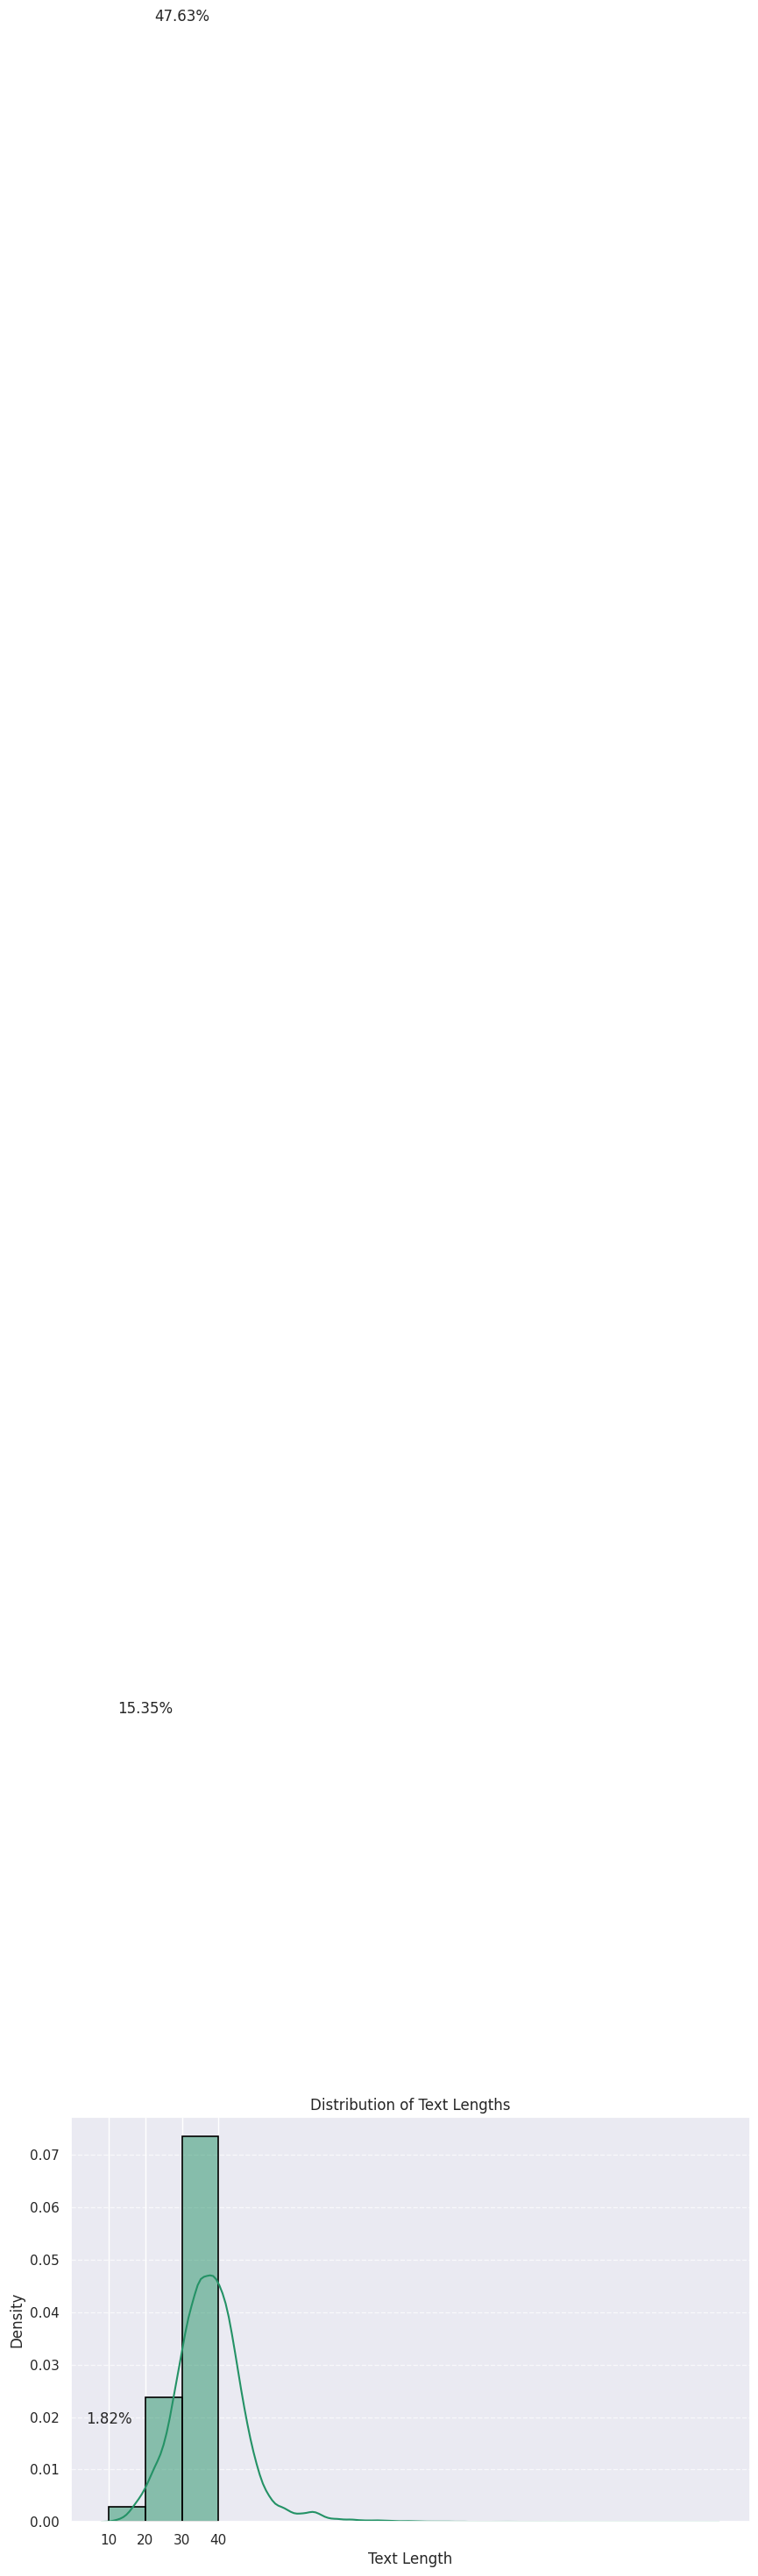

In [108]:

def show_textlen_buckets(text_buckets, preprocess=True):
    total_texts = len(text_buckets)
    bucket_boundaries = [10, 20, 30, 40, 50]
    text_lengths = []

    for text in text_buckets:
        if preprocess:
            text = preprocess_text(text)
        text_length = len(text.split())
        text_lengths.append(text_length)

    plt.figure(figsize=(10, 6))
    sns.histplot(text_lengths, bins=bucket_boundaries[:-1], kde=True, stat='density', alpha=0.5, edgecolor='black', linewidth=1.2)
    plt.xlabel('Text Length')
    plt.ylabel('Density')
    plt.title('Distribution of Text Lengths')
    plt.xticks(bucket_boundaries[:-1])
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Show percentage text on top of each bar
    bin_counts, _ = np.histogram(text_lengths, bins=bucket_boundaries[:-1])
    for i, count in enumerate(bin_counts):
        plt.text(bucket_boundaries[i], count/total_texts, f'{count/total_texts*100:.2f}%', ha='center', va='bottom')
    plt.show()

show_textlen_buckets(X, preprocess=False)